Sticking with the same AHU that we've been working with all along, load 6-months of data for all the points mapped to it. We'll be using these time series to see if we can find some interesting multivarant motifs/discords

In [420]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import urllib.parse
import requests
from sqlalchemy import create_engine

# Open the Database that contains point metadata (PostgresQL)
db_passwd = urllib.parse.quote_plus("gzaUjNfp2K$q0sxQ#^N9")
db_url = 'postgresql://postgresadmin:' + db_passwd + '@localhost:5434/resolute_cloud_dev'
alchemyEngine = create_engine(db_url)
conn = alchemyEngine.connect()

# Load an equipment instances' mapped data points
customer_id = 12  # Redico
parent_id = 151526  # dominosFarms/points/BAS/Ph2/AHU/AH21
query = '''
        select customer_uuid, metric_id, display_name, unit_id, is_cov 
            from mapped_points mp
            join point_point_templates ppt on ppt.node_id = mp.id
            join node_tags nt on nt.node_id = mp.parent_id
                where customer_id = %s
                and parent_id = %s;
    '''
sql = query % (customer_id, parent_id)
mapped_points = pd.read_sql_query(sql, conn)

In [421]:
# Build an timeseries index that will be used to position the input metrics. At the end of the day,
# the idea is to have one sample from each metric at each of the index locations.
today = pd.Timestamp.now(tz="UTC").replace(hour=0, minute=15, second=0, microsecond=0)
stime = today - pd.Timedelta(26, unit='W') - pd.Timedelta(days=today.weekday())
etime = (stime + pd.Timedelta(26, unit='W')).replace(hour=0, minute=0, second=0, microsecond=0)
inx = pd.date_range(stime, freq='15T', end=etime)

In [422]:
# Now the fun part. For us to find motif/discords there needs to be a sample at each of
# the periodic sample periods defined by the index we just built. And that sample has to 
# have the correct precision and then normalized. 
#
# Data *WILL* be missing, maybe at the sart, maybe at the end or maybe there will be holes
# in the data. The trick is to fill these holes with sensible values that will have minimum
# impact on the algorithm that is searching for motifs and discords
df = pd.DataFrame(index=inx)
base_url =  "http://localhost:4242/api/query?start=%s&end=%s&ms=true&m=sum:{custUUID}.{mertic_id}" %(
                int(stime.value/1000000), int(etime.value/1000000))
for i in range(len(mapped_points)):
    url = base_url.format(custUUID=mapped_points.loc[i, 'customer_uuid'], mertic_id=mapped_points.loc[i, 'metric_id'])
    r = requests.get(url)
    ts = r.json()[0]['dps']
    metric_ts = pd.DataFrame.from_dict(ts, orient='index', columns=['sample'])

# Precision of the data is adjusted here. For everything but pressures, integer values are
# enough. 
    if mapped_points.loc[i, 'unit_id'] != 24:
        metric_ts = metric_ts.round(decimals=0)

# Align everything on sample boundaries
    metric_ts.index = pd.to_datetime(metric_ts.index, unit='ms', utc=True, origin='unix')
    metric_ts = metric_ts.reindex(inx, method='nearest', limit=1)
    df[mapped_points.loc[i,'display_name']] = metric_ts['sample']

# At this moment, there's some weirdness that causes Niagara to return spurious zero values.
# The spurious zero values are across all values for the equipment instance, except for change
# of values. There's no certain way to detect this. The best I've been able to come up with
# is to to assume that if all the non-computed mapped point are zero for a time period,
# then assume they are all spurious. Zap spurious and allow them to be filled below
not_cov_cols = mapped_points[~mapped_points['is_cov']]['display_name'].tolist()
zeros = (df.fillna(0)[not_cov_cols] == 0).all(axis=1)
df[zeros] = np.nan

# Here's where we manufacture data. The assumption here is that no "hole" in the data will
# be more than a week. If violated, there may be flat spots in patterns, which will cause
# problems with motif/discord discovery. Shift holely data back a week and use it to fill
# Nans. There may be longer strings of missing data at beginning and at end. These are just
# filled with nearest (first, last) samples.
#
# This process will work with COV data, so long as at least one sample is returned. If none
# are returned the metric will be dropped.
for column in df:
    last_week = df[column].shift(7 * 24 * 4)
    df[column] = df[column].fillna(last_week)
    df[column] = df[column].fillna(method='bfill').fillna(method='ffill')
    
    # Since our distance calculations are based on Euclidean distances, normalize the samples
    # so no one metric overshadows another. This may not be strictly necessary with matrix profiles
    # but it does take care of any negative values. Oh, and if the values in the column never
    # changes, just drop it...it won't be any use to us for pattern matching.
    if df[column].diff().sum() == 0:
        del(df[column])
    else:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

In [423]:
df

,DARH,DAT,EntCHWT,FiltDP,LvgCHWT,MAT,MinOACFM,OARH,OAT,RARH,RAT,RFCFM,RFCFMStPt,SFCFM,Status
2020-12-21 00:15:00+00:00,0.129412,0.511111,0.717391,0.011518,0.586957,0.323077,1.000,0.726316,0.360825,0.396552,0.763441,0.300791,0.000000,0.134437,1.0
2020-12-21 00:30:00+00:00,0.129412,0.511111,0.695652,0.011518,0.586957,0.323077,1.000,0.736842,0.360825,0.396552,0.763441,0.300791,0.000000,0.134437,1.0
2020-12-21 00:45:00+00:00,0.129412,0.511111,0.717391,0.011518,0.586957,0.323077,1.000,0.747368,0.360825,0.396552,0.763441,0.300791,0.000000,0.134437,1.0
2020-12-21 01:00:00+00:00,0.129412,0.511111,0.717391,0.011518,0.586957,0.323077,1.000,0.747368,0.371134,0.396552,0.763441,0.300791,0.000000,0.134437,1.0
2020-12-21 01:15:00+00:00,0.129412,0.511111,0.717391,0.019895,0.586957,0.323077,1.000,0.747368,0.360825,0.396552,0.763441,0.300791,0.000000,0.134437,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-20 23:00:00+00:00,0.494118,0.888889,0.869565,0.004188,0.891304,0.630769,0.931,0.484211,0.886598,0.689655,0.956989,0.322689,0.015847,0.158940,0.0
2021-06-20 23:15:00+00:00,0.494118,0.888889,0.869565,0.011518,0.891304,0.630769,0.958,0.463158,0.896907,0.706897,0.956989,0.322689,0.010880,0.158940,0.0
2021-06-20 23:30:00+00:00,0.494118,0.888889,0.891304,0.004188,0.891304,0.630769,0.894,0.442105,0.927835,0.689655,0.956989,0.322689,0.022706,0.158940,0.0
2021-06-20 23:45:00+00:00,0.482353,0.888889,0.891304,0.015707,0.891304,0.630769,0.894,0.421053,0.927835,0.706897,0.956989,0.322689,0.022706,0.158940,0.0


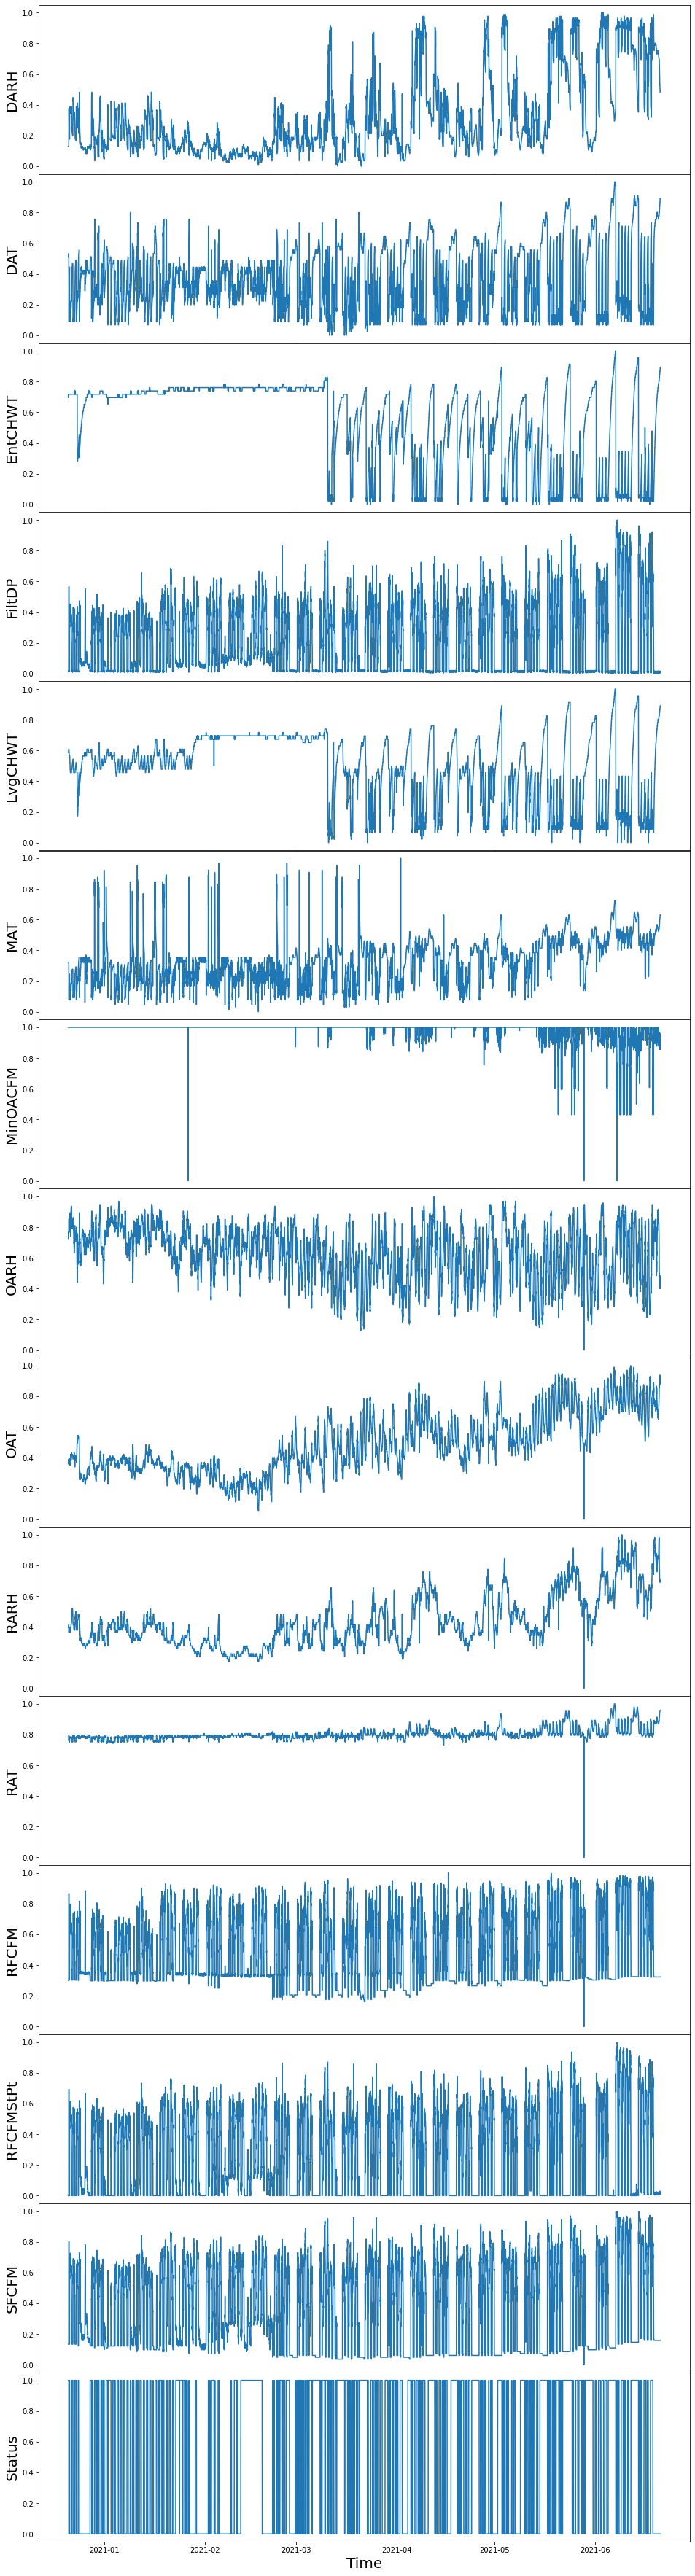

In [424]:

import stumpy

#plt.style.use('stumpy.mplstyle')
plt.rcParams["figure.figsize"] = [20, 6]  # width, height
plt.rcParams['xtick.direction'] = 'out'

fig, axs = plt.subplots(df.shape[1], sharex=True, gridspec_kw={'hspace': 0.001}, figsize=[16,64])

i = 0
for column in df:
    axs[i].set_ylabel(column, fontsize='20')
    axs[i].set_xlabel('Time', fontsize ='20')
    axs[i].plot(df[column])
    i += 1
    
plt.show()

In [425]:
mps, indices = stumpy.mstump(df, m=7 * 24 * 4, discords=True)

In [426]:
motifs_idx = np.argsort(mps, axis=1)[:, :2]

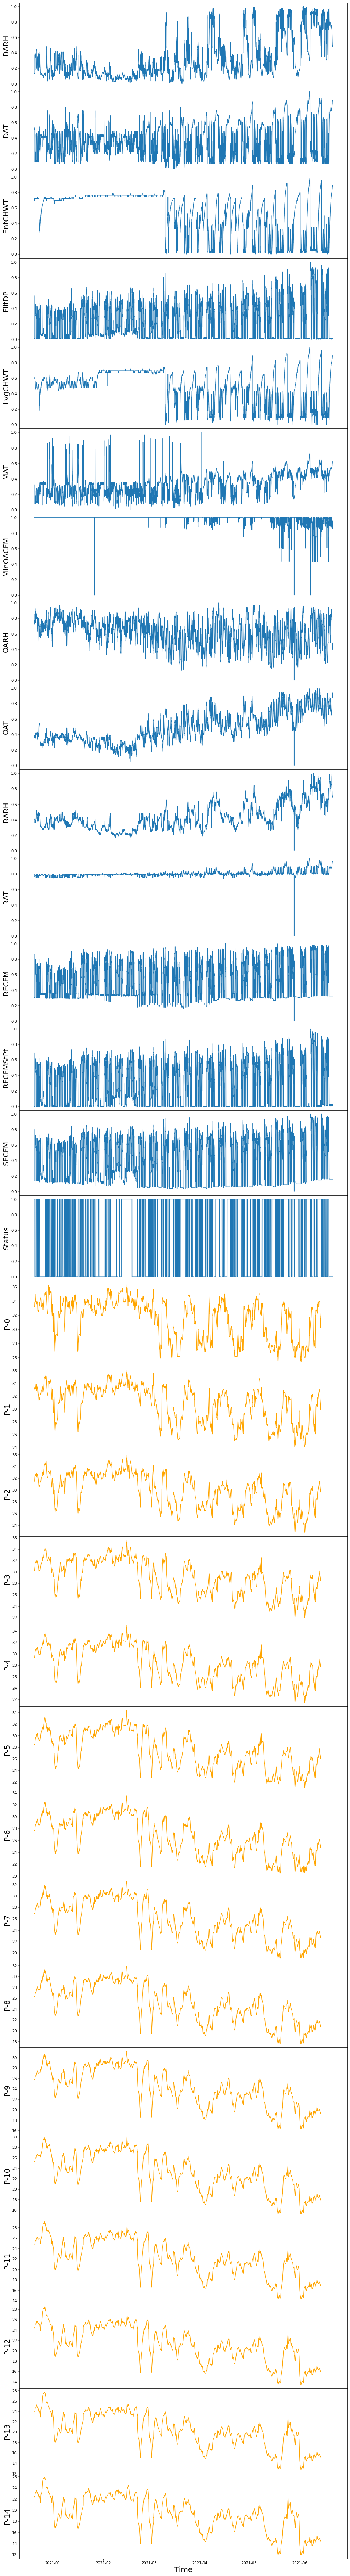

In [427]:
fig, axs = plt.subplots(mps.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0}, figsize=[16,128])

m = 7 * 24 * 4
for k, dim_name in enumerate(df.columns):
    axs[k].set_ylabel(dim_name, fontsize='20')
    axs[k].plot(df.index, df[dim_name])
    axs[k].set_xlabel('Time', fontsize ='20')
    axs[k + mps.shape[0]].set_ylabel('P-%s' % (int(k)), fontsize='20')
    axs[k + mps.shape[0]].plot(df.index[0:len(mps[k])], mps[k], c='orange')
    axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='20')

    axs[k].axvline(x=df.index[motifs_idx[2, 0]], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=df.index[motifs_idx[2, 0]], linestyle="dashed", c='black')

plt.show()

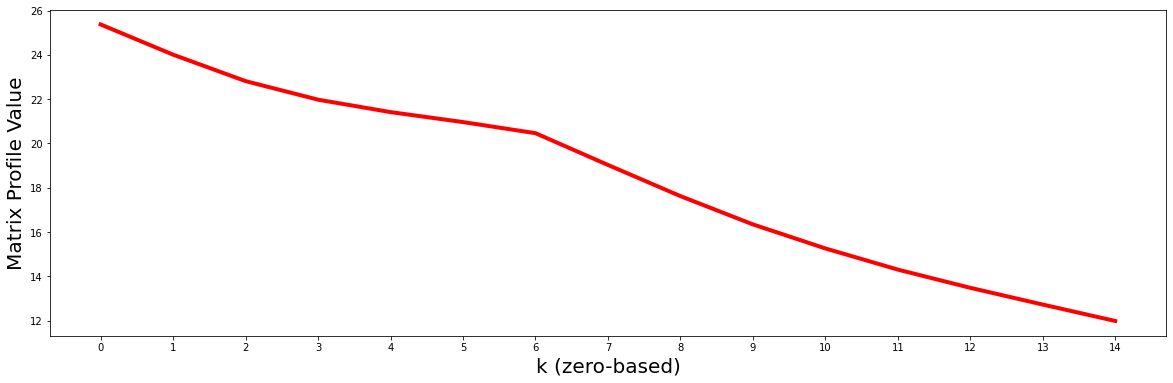

In [428]:
plt.plot(mps[range(mps.shape[0]), motifs_idx[:, 0]], c='red', linewidth='4')
plt.xlabel('k (zero-based)', fontsize='20')
plt.ylabel('Matrix Profile Value', fontsize='20')
plt.xticks(range(mps.shape[0]))
plt.show()

In [429]:
k = 6
S = stumpy.subspace(df, m, motifs_idx[k][0], indices[k][motifs_idx[k][0]], k)
print(f"For k = {k}, the {k + 1}-dimensional subspace includes subsequences from {df.columns[S].values}")

For k = 6, the 7-dimensional subspace includes subsequences from ['EntCHWT' 'LvgCHWT' 'DAT' 'SFCFM' 'RFCFMStPt' 'RFCFM' 'FiltDP']


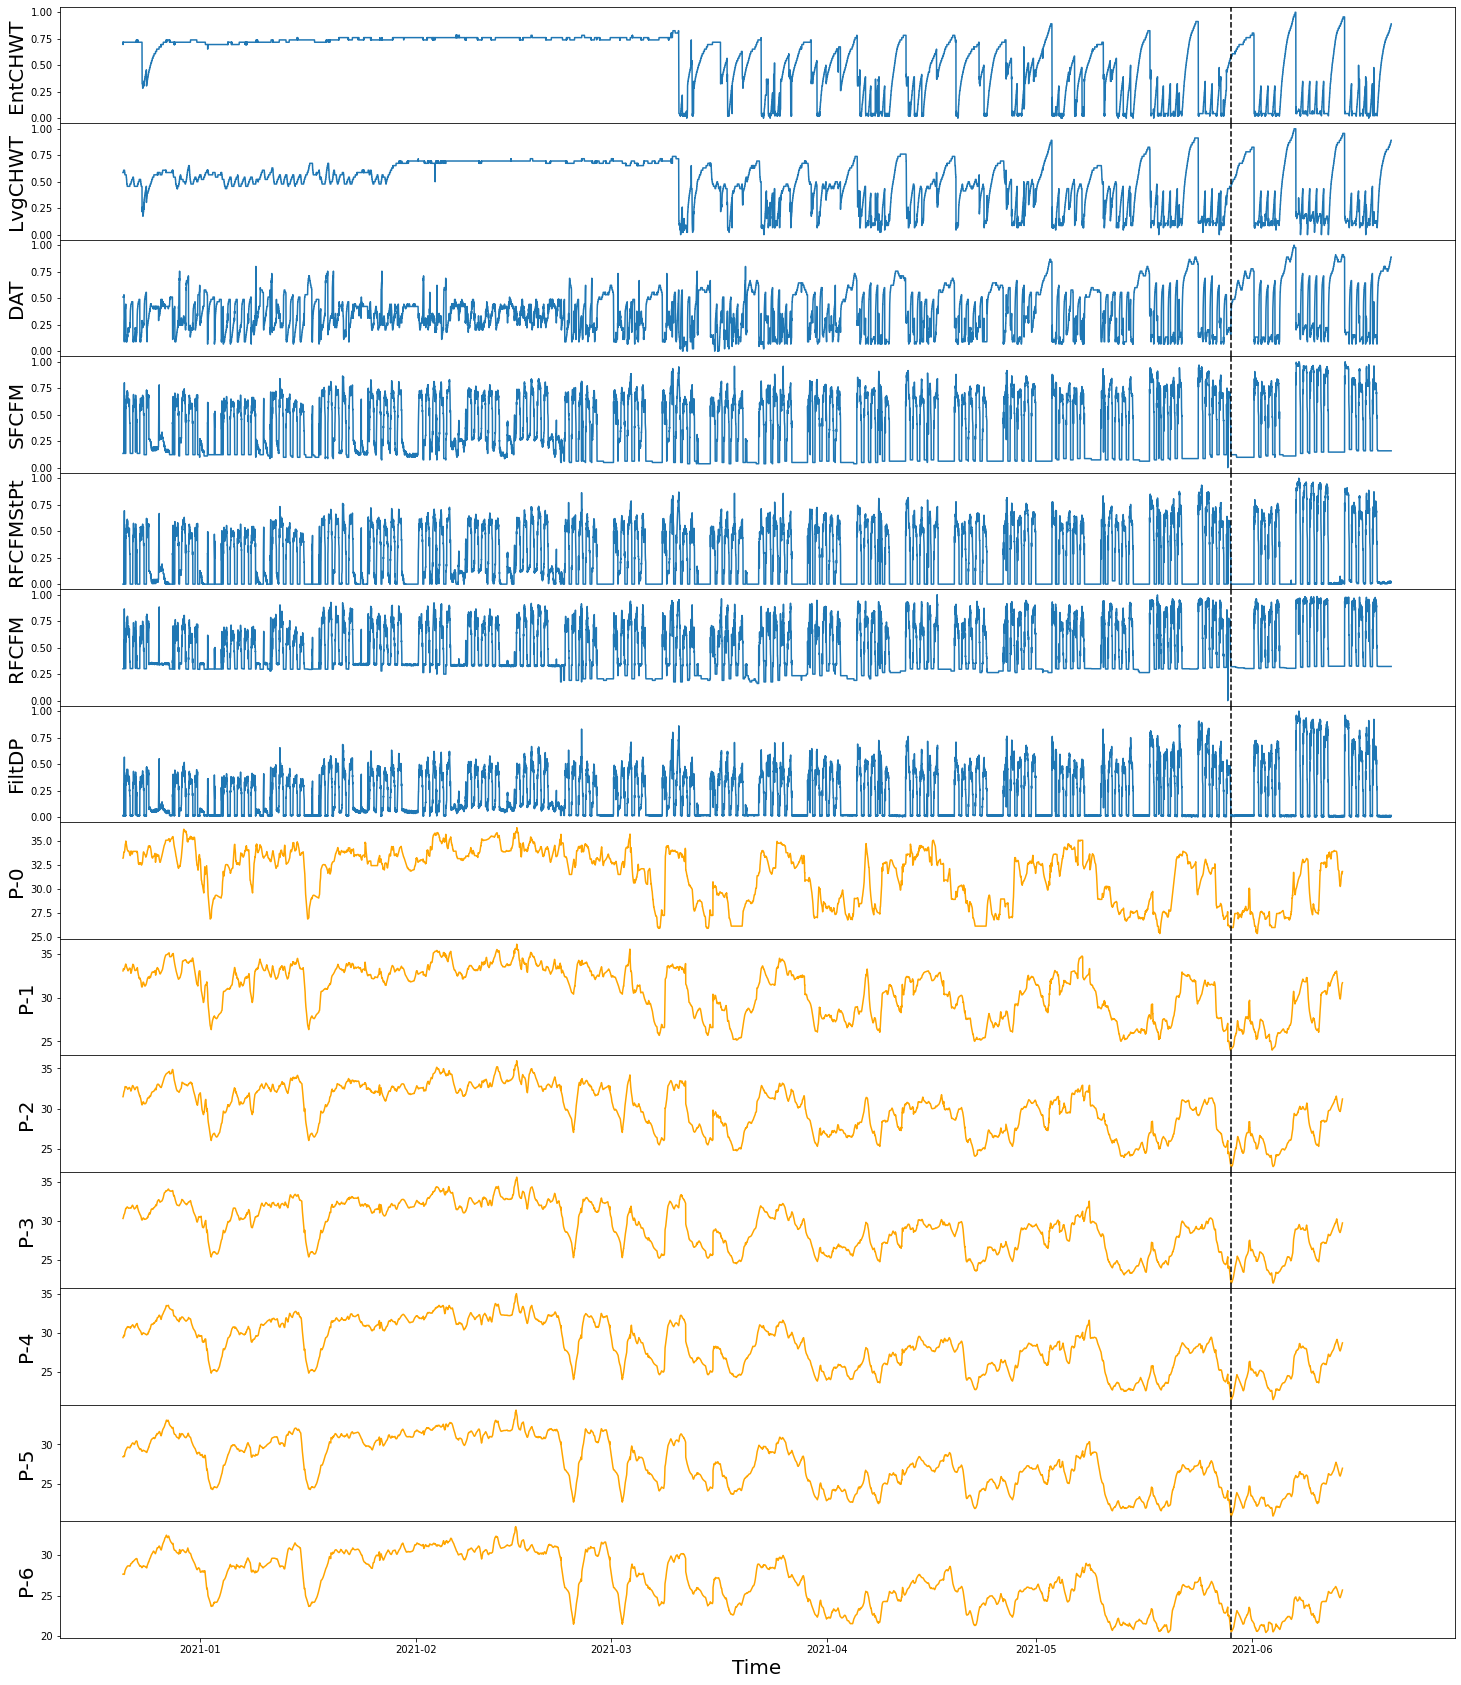

In [430]:
metrics = ['EntCHWT', 'LvgCHWT', 'DAT', 'SFCFM', 'RFCFMStPt', 'RFCFM', 'FiltDP']
fig, axs = plt.subplots(len(metrics) * 2, sharex=True, gridspec_kw={'hspace': 0}, figsize=[25,30])

m = 7 * 24 * 4
for k, dim_name in enumerate(metrics):
    axs[k].set_ylabel(dim_name, fontsize='20')
    axs[k].plot(df.index, df[dim_name])
    axs[k].set_xlabel('Time', fontsize ='20')
    axs[k + len(metrics)].set_ylabel('P-%s' % (int(k)), fontsize='20')
    axs[k + len(metrics)].plot(df.index[0:len(mps[k])], mps[k], c='orange')
    axs[k + len(metrics)].set_xlabel('Time', fontsize ='20')

    axs[k].axvline(x=df.index[motifs_idx[2, 0]], linestyle="dashed", c='black')
    axs[k + len(metrics)].axvline(x=df.index[motifs_idx[2, 0]], linestyle="dashed", c='black')

plt.show()

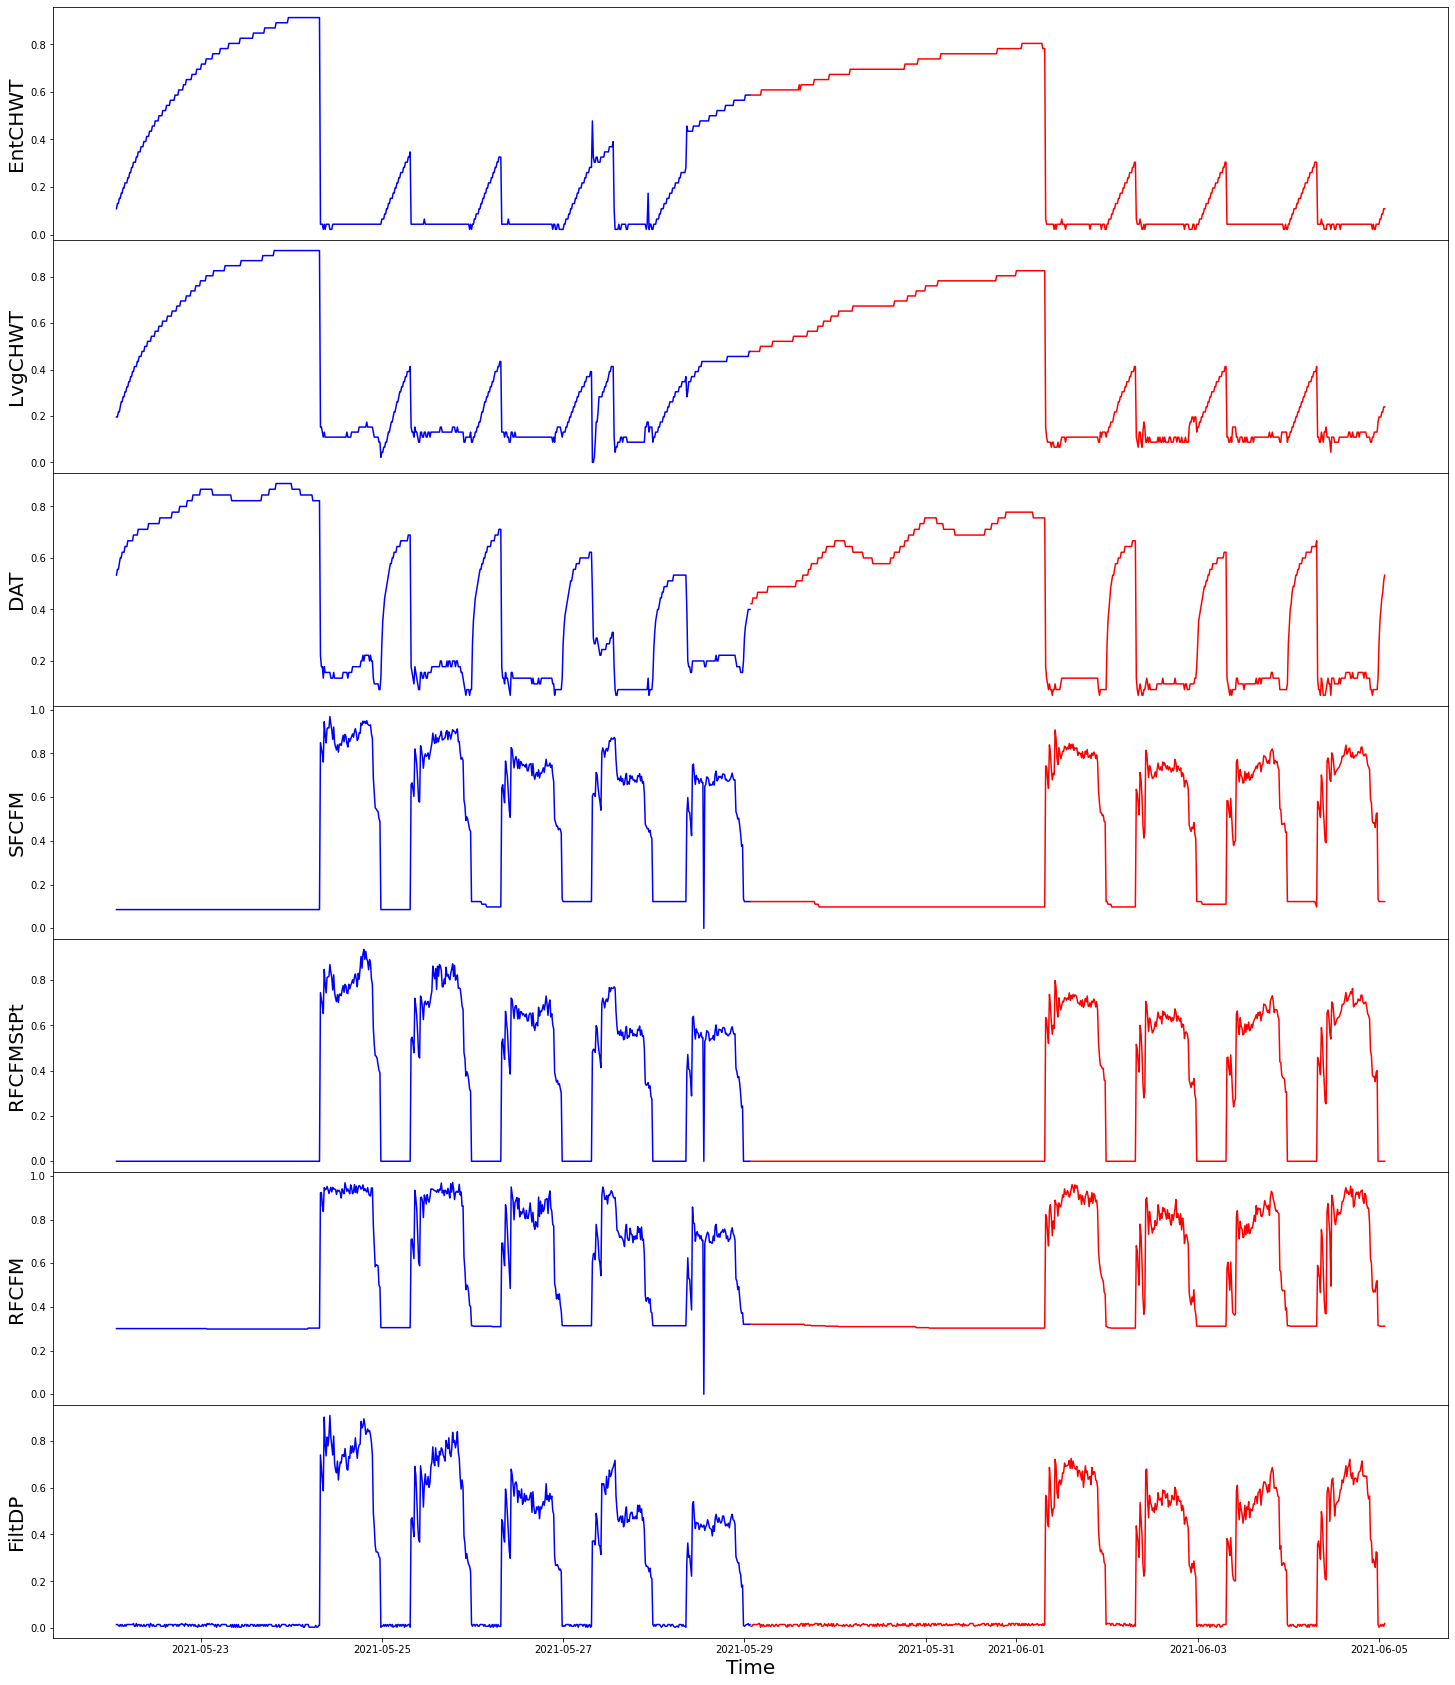

In [431]:
metrics = ['EntCHWT', 'LvgCHWT', 'DAT', 'SFCFM', 'RFCFMStPt', 'RFCFM', 'FiltDP']
fig, axs = plt.subplots(len(metrics), sharex=True, gridspec_kw={'hspace': 0},figsize=[25,30])

m = 7 * 24 * 4
previous_week = motifs_idx[2, 0] - m

for k, dim_name in enumerate(metrics):
    axs[k].set_ylabel(dim_name, fontsize='20')
    axs[k].plot(df.index[previous_week: previous_week + m], df[dim_name][previous_week : previous_week + m], color='blue')
    axs[k].plot(df.index[motifs_idx[2, 0]: motifs_idx[2, 0] + m], df[dim_name][motifs_idx[2, 0] :  motifs_idx[2, 0] + m], color='red')
    axs[k].set_xlabel('Time', fontsize ='20')
    
plt.show()